In [ ]:
import pandas as pd
import numpy as np

%config Completer.use_jedi = False

!gdown https://drive.google.com/uc?id=1eJwo5GHHeZ-fDQVniwL1GpARP5H_U-l2

path = "/content/Retail_Online_30.xlsx"

data = pd.read_excel(path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  after removing the cwd from sys.path.


Downloading...
From: https://drive.google.com/uc?id=1eJwo5GHHeZ-fDQVniwL1GpARP5H_U-l2
To: /content/Retail_Online_30.xlsx
100% 9.64M/9.64M [00:00<00:00, 77.2MB/s]


In [ ]:
data['Description'] = data['Description'].str.strip() #removes spaces from beginning and end
data.dropna(axis=0, subset=['Invoice'], inplace=True) #removes duplicate invoice
data['Invoice'] = data['Invoice'].astype('str') #converting invoice number to be string
data = data[~data['Invoice'].str.contains('C')] #remove the credit transactions 
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,PostalCode,Country,Monto_total
3,536366.0,22632.0,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
4,536368.0,22960.0,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047.0,United Kingdom,25.50
5,536368.0,22913.0,RED COAT RACK PARIS FASHION,3,2010-12-01 08:34:00,4.95,13047.0,United Kingdom,14.85
6,536368.0,22912.0,YELLOW COAT RACK PARIS FASHION,3,2010-12-01 08:34:00,4.95,13047.0,United Kingdom,14.85
7,536367.0,84879.0,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,54.08


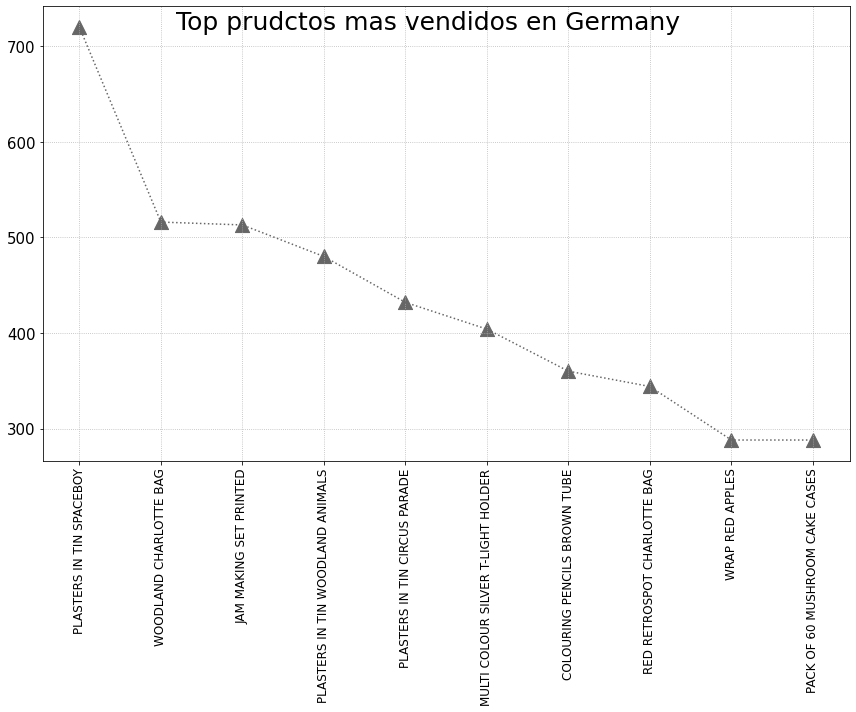

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})


country = "Germany"
vals = (
data[data.Country == country]
.groupby(['Invoice', 'Description'])['Quantity']
.sum()
.unstack(-1).reset_index().fillna(0)
.set_index('Invoice')
).sum().sort_values(ascending=False)
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot()
ax.plot(vals.values[:10], linestyle='dotted', c='0.4')
ax.scatter(range(10), vals.values[:10], marker='^', s=200, c='0.4')
ax.set_xticks(range(10)) 
ax.set_xticklabels(vals.index[10:], fontsize=12, rotation=90)
ax.grid(True, color='0.7', linestyle='dotted')
ax.tick_params(axis='y', labelsize=15)
fig.suptitle("Top prudctos mas vendidos en {}".format(country), fontsize=25)

fig.savefig('asd.png')
plt.show()

# basket market analizing

In [ ]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,PostalCode,Country,Monto_total
0,536365.0,NaN,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365.0,NaN,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365.0,NaN,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
3,536366.0,22632.0,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
4,536368.0,22960.0,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047.0,United Kingdom,25.50


In [ ]:
data.Country.value_counts()

United Kingdom          130762
Germany                   2380
France                    2325
EIRE                      2201
Spain                      709
Netherlands                656
Belgium                    528
Switzerland                516
Portugal                   408
Australia                  360
Norway                     297
Channel Islands            216
Italy                      205
Cyprus                     174
Finland                    166
Sweden                     115
Unspecified                115
Denmark                    105
Austria                    103
Japan                       95
Hong Kong                   88
Israel                      82
Poland                      80
Singapore                   60
USA                         50
Canada                      45
Iceland                     40
Greece                      38
United Arab Emirates        24
Malta                       23
Lebanon                     18
RSA                         14
European

In [ ]:
country_study = list(data.Country.value_counts()[data.Country.value_counts() >= 95].index)
country_study

['United Kingdom',
 'Germany',
 'France',
 'EIRE',
 'Spain',
 'Netherlands',
 'Belgium',
 'Switzerland',
 'Portugal',
 'Australia',
 'Norway',
 'Channel Islands',
 'Italy',
 'Cyprus',
 'Finland',
 'Sweden',
 'Unspecified',
 'Denmark',
 'Austria',
 'Japan']

### Estudiamos los paises mas interesantes, segun la cantidad de ventas (japon min 95)

In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from tqdm.notebook import tqdm

data = data[data.StockCode.notna()]
tresh_0 = 0.003
tresh_f = 0.1
treshs = np.linspace(tresh_0, tresh_f, num=len(country_study))
all_top_3 = None
i = 0
for country in tqdm(country_study[:8], ncols=1000):
    basket = (data[data.Country == country]
              .groupby(['Invoice', 'Description'])['Quantity']
              .sum().unstack(-1).reset_index().fillna(0)
              .set_index('Invoice'))
    
    cols_ = data['Description'].dropna().str.isupper()
    cols_ = data['Description'].dropna()[cols_]
    gcolumns = set(cols_).intersection(basket.columns)
    fi = apriori(basket[gcolumns] > 0, use_colnames=True, min_support=treshs[i])
    rules = association_rules(fi, metric="lift", min_threshold=0.8)
    top_3 = rules.sort_values('lift', ascending=False)[:3]
    top_3['Country'] = country
    if all_top_3 is None:
        all_top_3 = top_3
    else:
        all_top_3 = pd.concat([all_top_3, top_3])
    i += 1

  0%|                                                                                                         …

                          antecedents  ...         Country
15           (WOODLAND CHARLOTTE BAG)  ...  United Kingdom
14        (CHARLOTTE BAG SUKI DESIGN)  ...  United Kingdom
0   (ROSES REGENCY TEACUP AND SAUCER)  ...  United Kingdom

[3 rows x 10 columns]
                           antecedents  ...  Country
2           (COFFEE MUG PEARS  DESIGN)  ...  Germany
3           (COFFEE MUG APPLES DESIGN)  ...  Germany
6  (ROUND SNACK BOXES SET OF 4 FRUITS)  ...  Germany

[3 rows x 10 columns]
                        antecedents  ... Country
12  (SET/6 RED SPOTTY PAPER PLATES)  ...  France
13    (SET/6 RED SPOTTY PAPER CUPS)  ...  France
0       (LUNCH BAG SPACEBOY DESIGN)  ...  France

[3 rows x 10 columns]
                  antecedents                   consequents  ...  conviction  Country
2  (REGENCY SUGAR BOWL GREEN)        (REGENCY TEAPOT ROSES)  ...    2.411765     EIRE
3      (REGENCY TEAPOT ROSES)    (REGENCY SUGAR BOWL GREEN)  ...    2.882353     EIRE
1        (VINTAGE SNAP CARDS)

In [ ]:
all_top_3

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Country
15,(WOODLAND CHARLOTTE BAG),(CHARLOTTE BAG SUKI DESIGN),0.013532,0.015502,0.003113,0.230047,14.839914,0.002903,1.278647,United Kingdom
14,(CHARLOTTE BAG SUKI DESIGN),(WOODLAND CHARLOTTE BAG),0.015502,0.013532,0.003113,0.200820,14.839914,0.002903,1.234349,United Kingdom
0,(ROSES REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.019250,0.013977,0.003748,0.194719,13.931293,0.003479,1.224446,United Kingdom
2,(COFFEE MUG PEARS DESIGN),(COFFEE MUG APPLES DESIGN),0.017722,0.027848,0.010127,0.571429,20.519481,0.009633,2.268354,Germany
3,(COFFEE MUG APPLES DESIGN),(COFFEE MUG PEARS DESIGN),0.027848,0.017722,0.010127,0.363636,20.519481,0.009633,1.543580,Germany
6,(ROUND SNACK BOXES SET OF 4 FRUITS),(WOODLAND CHARLOTTE BAG),0.053165,0.045570,0.012658,0.238095,5.224868,0.010236,1.252690,Germany
12,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.048159,0.036827,0.016997,0.352941,9.583710,0.015224,1.488540,France
13,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.036827,0.048159,0.016997,0.461538,9.583710,0.015224,1.767705,France
0,(LUNCH BAG SPACEBOY DESIGN),(SPACEBOY LUNCH BOX),0.053824,0.056657,0.014164,0.263158,4.644737,0.011115,1.280251,France
2,(REGENCY SUGAR BOWL GREEN),(REGENCY TEAPOT ROSES),0.039216,0.035294,0.023529,0.600000,17.000000,0.022145,2.411765,EIRE


In [ ]:
all_top_3.to_excel('/content/top3.xlsx')